## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras import regularizers

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],
              use_bn=True, drp_ratio=0., l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Activation("relu")(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            x = Activation("relu")(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
USE_BN = [True, False]
DRP_RATIO = [0., 0.2, 0.4]
L2_RATIO = [0., 1e-4, 1e-8]

In [7]:
results = {}

import itertools
for use_bn, drp_ratio, l2_ratio in itertools.product(USE_BN, DRP_RATIO, L2_RATIO):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Batch Normalization: {use_bn}, Dropout ratio: {drp_ratio}, L2 regularization ratio: {l2_ratio}")
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = (f"Batch Normalization: {use_bn}, Dropout ratio: {drp_ratio}, L2 regularization ratio: {l2_ratio}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Batch Normalization: True, Dropout ratio: 0.0, L2 regularization ratio: 0.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)          

Epoch 1/30



196/196 [==============================] - 9s 28ms/step - loss: 1.7003 - accuracy: 0.4037 - val_loss: 1.8969 - val_accuracy: 0.3431
Epoch 2/30
196/196 [==============================] - 5s 24ms/step - loss: 1.4808 - accuracy: 0.4787 - val_loss: 1.9041 - val_accuracy: 0.3337
Epoch 3/30
196/196 [==============================] - 7s 38ms/step - loss: 1.3792 - accuracy: 0.5110 - val_loss: 2.0161 - val_accuracy: 0.3515
Epoch 4/30
196/196 [==============================] - 7s 38ms/step - loss: 1.3080 - accuracy: 0.5376 - val_loss: 1.7032 - val_accuracy: 0.4069
Epoch 5/30
196/196 [==============================] - 7s 37ms/step - loss: 1.2570 - accuracy: 0.5525 - val_loss: 1.6321 - val_accuracy: 0.4106
Epoch 6/30
196/196 [==============================] - 6s 28ms/step - loss: 1.2138 - accuracy: 0.5682 - val_loss: 1.8370 - val_accuracy: 0.3693
Epoch 7/30
196/196 [==============================] - 5s 26ms/step - loss: 1.1693 - accuracy: 0.5851 - val_loss: 1.6764 - val_accuracy: 0.4101
Epoch 8/30

Epoch 1/30
196/196 [==============================] - 9s 30ms/step - loss: 1.8302 - accuracy: 0.4056 - val_loss: 2.0459 - val_accuracy: 0.3406
Epoch 2/30
196/196 [==============================] - 4s 22ms/step - loss: 1.6115 - accuracy: 0.4773 - val_loss: 1.9540 - val_accuracy: 0.3495
Epoch 3/30
196/196 [==============================] - 5s 26ms/step - loss: 1.5143 - accuracy: 0.5095 - val_loss: 2.3255 - val_accuracy: 0.3160
Epoch 4/30
196/196 [==============================] - 5s 25ms/step - loss: 1.4541 - accuracy: 0.5297 - val_loss: 2.1471 - val_accuracy: 0.3445
Epoch 5/30
196/196 [==============================] - 5s 26ms/step - loss: 1.4095 - accuracy: 0.5466 - val_loss: 2.4993 - val_accuracy: 0.2851
Epoch 6/30
196/196 [==============================] - 4s 22ms/step - loss: 1.3726 - accuracy: 0.5592 - val_loss: 2.0129 - val_accuracy: 0.3594
Epoch 7/30
196/196 [==============================] - 5s 25ms/step - loss: 1.3132 - accuracy: 0.5802 - val_loss: 1.9164 - val_accuracy: 0.4059

Epoch 1/30
196/196 [==============================] - 9s 33ms/step - loss: 1.6861 - accuracy: 0.4072 - val_loss: 1.6689 - val_accuracy: 0.4089
Epoch 2/30
196/196 [==============================] - 5s 24ms/step - loss: 1.4811 - accuracy: 0.4747 - val_loss: 1.8202 - val_accuracy: 0.3612
Epoch 3/30
196/196 [==============================] - 5s 25ms/step - loss: 1.3821 - accuracy: 0.5101 - val_loss: 1.8134 - val_accuracy: 0.3723
Epoch 4/30
196/196 [==============================] - 4s 19ms/step - loss: 1.3154 - accuracy: 0.5333 - val_loss: 1.6180 - val_accuracy: 0.4249
Epoch 5/30
196/196 [==============================] - 3s 16ms/step - loss: 1.2580 - accuracy: 0.5547 - val_loss: 1.6943 - val_accuracy: 0.4081
Epoch 6/30
196/196 [==============================] - 3s 18ms/step - loss: 1.2058 - accuracy: 0.5724 - val_loss: 1.7979 - val_accuracy: 0.3922
Epoch 7/30
196/196 [==============================] - 3s 17ms/step - loss: 1.1590 - accuracy: 0.5903 - val_loss: 1.7892 - val_accuracy: 0.4057

Epoch 1/30
196/196 [==============================] - 10s 30ms/step - loss: 1.9245 - accuracy: 0.3310 - val_loss: 1.9732 - val_accuracy: 0.3416
Epoch 2/30
196/196 [==============================] - 5s 24ms/step - loss: 1.6617 - accuracy: 0.4096 - val_loss: 1.7506 - val_accuracy: 0.3823
Epoch 3/30
196/196 [==============================] - 5s 24ms/step - loss: 1.5773 - accuracy: 0.4396 - val_loss: 1.6414 - val_accuracy: 0.4085
Epoch 4/30
196/196 [==============================] - 5s 24ms/step - loss: 1.5213 - accuracy: 0.4574 - val_loss: 1.5684 - val_accuracy: 0.4487
Epoch 5/30
196/196 [==============================] - 5s 24ms/step - loss: 1.4904 - accuracy: 0.4676 - val_loss: 1.6123 - val_accuracy: 0.4192
Epoch 6/30
196/196 [==============================] - 5s 23ms/step - loss: 1.4705 - accuracy: 0.4723 - val_loss: 1.5963 - val_accuracy: 0.4245
Epoch 7/30
196/196 [==============================] - 5s 23ms/step - loss: 1.4474 - accuracy: 0.4845 - val_loss: 1.5525 - val_accuracy: 0.445

Epoch 1/30
196/196 [==============================] - 7s 26ms/step - loss: 2.0856 - accuracy: 0.3275 - val_loss: 1.9113 - val_accuracy: 0.3669
Epoch 2/30
196/196 [==============================] - 5s 24ms/step - loss: 1.8040 - accuracy: 0.4070 - val_loss: 1.8206 - val_accuracy: 0.3900
Epoch 3/30
196/196 [==============================] - 5s 23ms/step - loss: 1.7101 - accuracy: 0.4344 - val_loss: 1.8546 - val_accuracy: 0.3771
Epoch 4/30
196/196 [==============================] - 5s 23ms/step - loss: 1.6581 - accuracy: 0.4552 - val_loss: 1.8449 - val_accuracy: 0.3703
Epoch 5/30
196/196 [==============================] - 5s 23ms/step - loss: 1.6340 - accuracy: 0.4586 - val_loss: 1.8898 - val_accuracy: 0.3859
Epoch 6/30
196/196 [==============================] - 4s 23ms/step - loss: 1.6015 - accuracy: 0.4690 - val_loss: 1.6813 - val_accuracy: 0.4429
Epoch 7/30
196/196 [==============================] - 5s 24ms/step - loss: 1.5836 - accuracy: 0.4749 - val_loss: 1.7235 - val_accuracy: 0.4186

Epoch 1/30
196/196 [==============================] - 8s 27ms/step - loss: 1.9445 - accuracy: 0.3316 - val_loss: 1.8554 - val_accuracy: 0.3416
Epoch 2/30
196/196 [==============================] - 4s 23ms/step - loss: 1.6815 - accuracy: 0.4011 - val_loss: 1.6801 - val_accuracy: 0.4010
Epoch 3/30
196/196 [==============================] - 4s 22ms/step - loss: 1.5877 - accuracy: 0.4338 - val_loss: 1.9303 - val_accuracy: 0.3205
Epoch 4/30
196/196 [==============================] - 4s 22ms/step - loss: 1.5317 - accuracy: 0.4539 - val_loss: 1.5905 - val_accuracy: 0.4250
Epoch 5/30
196/196 [==============================] - 4s 22ms/step - loss: 1.4961 - accuracy: 0.4654 - val_loss: 1.5857 - val_accuracy: 0.4314
Epoch 6/30
196/196 [==============================] - 4s 22ms/step - loss: 1.4751 - accuracy: 0.4740 - val_loss: 1.5403 - val_accuracy: 0.4484
Epoch 7/30
196/196 [==============================] - 4s 22ms/step - loss: 1.4514 - accuracy: 0.4813 - val_loss: 1.4994 - val_accuracy: 0.4651

Epoch 1/30
196/196 [==============================] - 4s 15ms/step - loss: 2.2363 - accuracy: 0.2593 - val_loss: 1.7807 - val_accuracy: 0.3569
Epoch 2/30
196/196 [==============================] - 3s 13ms/step - loss: 1.8500 - accuracy: 0.3395 - val_loss: 1.7929 - val_accuracy: 0.3420
Epoch 3/30
196/196 [==============================] - 3s 13ms/step - loss: 1.7509 - accuracy: 0.3721 - val_loss: 1.7519 - val_accuracy: 0.3707
Epoch 4/30
196/196 [==============================] - 3s 13ms/step - loss: 1.6962 - accuracy: 0.3929 - val_loss: 1.6856 - val_accuracy: 0.3849
Epoch 5/30
196/196 [==============================] - 3s 13ms/step - loss: 1.6629 - accuracy: 0.4022 - val_loss: 1.6872 - val_accuracy: 0.3973
Epoch 6/30
196/196 [==============================] - 3s 13ms/step - loss: 1.6417 - accuracy: 0.4139 - val_loss: 1.7075 - val_accuracy: 0.3975
Epoch 7/30
196/196 [==============================] - 3s 13ms/step - loss: 1.6361 - accuracy: 0.4163 - val_loss: 1.5819 - val_accuracy: 0.4245

Epoch 1/30
196/196 [==============================] - 4s 14ms/step - loss: 2.3702 - accuracy: 0.2657 - val_loss: 1.9885 - val_accuracy: 0.3295
Epoch 2/30
196/196 [==============================] - 3s 13ms/step - loss: 1.9866 - accuracy: 0.3399 - val_loss: 1.8973 - val_accuracy: 0.3556
Epoch 3/30
196/196 [==============================] - 3s 13ms/step - loss: 1.8756 - accuracy: 0.3739 - val_loss: 1.9779 - val_accuracy: 0.3214
Epoch 4/30
196/196 [==============================] - 3s 13ms/step - loss: 1.8234 - accuracy: 0.3912 - val_loss: 1.9374 - val_accuracy: 0.3458
Epoch 5/30
196/196 [==============================] - 3s 13ms/step - loss: 1.7914 - accuracy: 0.3996 - val_loss: 1.8617 - val_accuracy: 0.3672
Epoch 6/30
196/196 [==============================] - 3s 13ms/step - loss: 1.7616 - accuracy: 0.4096 - val_loss: 1.6962 - val_accuracy: 0.4387
Epoch 7/30
196/196 [==============================] - 3s 13ms/step - loss: 1.7488 - accuracy: 0.4143 - val_loss: 1.6717 - val_accuracy: 0.4343

Epoch 1/30
196/196 [==============================] - 4s 14ms/step - loss: 2.2267 - accuracy: 0.2647 - val_loss: 1.7386 - val_accuracy: 0.3851
Epoch 2/30
196/196 [==============================] - 3s 13ms/step - loss: 1.8431 - accuracy: 0.3443 - val_loss: 1.7050 - val_accuracy: 0.3813
Epoch 3/30
196/196 [==============================] - 3s 13ms/step - loss: 1.7424 - accuracy: 0.3776 - val_loss: 1.6759 - val_accuracy: 0.3948
Epoch 4/30
196/196 [==============================] - 2s 13ms/step - loss: 1.6924 - accuracy: 0.3954 - val_loss: 1.6546 - val_accuracy: 0.4036
Epoch 5/30
196/196 [==============================] - 3s 13ms/step - loss: 1.6634 - accuracy: 0.4033 - val_loss: 1.6251 - val_accuracy: 0.4120
Epoch 6/30
196/196 [==============================] - 3s 13ms/step - loss: 1.6486 - accuracy: 0.4100 - val_loss: 1.5573 - val_accuracy: 0.4511
Epoch 7/30
196/196 [==============================] - 3s 13ms/step - loss: 1.6240 - accuracy: 0.4183 - val_loss: 1.5874 - val_accuracy: 0.4302

Epoch 1/30
196/196 [==============================] - 4s 12ms/step - loss: 1.9405 - accuracy: 0.3014 - val_loss: 1.7776 - val_accuracy: 0.3747
Epoch 2/30
196/196 [==============================] - 2s 11ms/step - loss: 1.7189 - accuracy: 0.3851 - val_loss: 1.6746 - val_accuracy: 0.4046
Epoch 3/30
196/196 [==============================] - 2s 11ms/step - loss: 1.6190 - accuracy: 0.4219 - val_loss: 1.5717 - val_accuracy: 0.4390
Epoch 4/30
196/196 [==============================] - 2s 11ms/step - loss: 1.5503 - accuracy: 0.4467 - val_loss: 1.5949 - val_accuracy: 0.4366
Epoch 5/30
196/196 [==============================] - 2s 11ms/step - loss: 1.4997 - accuracy: 0.4660 - val_loss: 1.5467 - val_accuracy: 0.4453
Epoch 6/30
196/196 [==============================] - 2s 11ms/step - loss: 1.4617 - accuracy: 0.4775 - val_loss: 1.4848 - val_accuracy: 0.4681
Epoch 7/30
196/196 [==============================] - 2s 11ms/step - loss: 1.4421 - accuracy: 0.4854 - val_loss: 1.4676 - val_accuracy: 0.4771

Epoch 1/30
196/196 [==============================] - 3s 12ms/step - loss: 2.0233 - accuracy: 0.3080 - val_loss: 1.8481 - val_accuracy: 0.3607
Epoch 2/30
196/196 [==============================] - 2s 11ms/step - loss: 1.7924 - accuracy: 0.3855 - val_loss: 1.7243 - val_accuracy: 0.4069
Epoch 3/30
196/196 [==============================] - 2s 10ms/step - loss: 1.6842 - accuracy: 0.4194 - val_loss: 1.6778 - val_accuracy: 0.4226
Epoch 4/30
196/196 [==============================] - 2s 11ms/step - loss: 1.6132 - accuracy: 0.4453 - val_loss: 1.6284 - val_accuracy: 0.4410
Epoch 5/30
196/196 [==============================] - 2s 11ms/step - loss: 1.5673 - accuracy: 0.4599 - val_loss: 1.5591 - val_accuracy: 0.4653
Epoch 6/30
196/196 [==============================] - 2s 11ms/step - loss: 1.5167 - accuracy: 0.4771 - val_loss: 1.5298 - val_accuracy: 0.4772
Epoch 7/30
196/196 [==============================] - 2s 11ms/step - loss: 1.4967 - accuracy: 0.4828 - val_loss: 1.4980 - val_accuracy: 0.4806

Epoch 1/30
196/196 [==============================] - 3s 11ms/step - loss: 1.9336 - accuracy: 0.3039 - val_loss: 1.7723 - val_accuracy: 0.3596
Epoch 2/30
196/196 [==============================] - 2s 11ms/step - loss: 1.7089 - accuracy: 0.3867 - val_loss: 1.6365 - val_accuracy: 0.4165
Epoch 3/30
196/196 [==============================] - 2s 11ms/step - loss: 1.6213 - accuracy: 0.4218 - val_loss: 1.5834 - val_accuracy: 0.4363
Epoch 4/30
196/196 [==============================] - 2s 11ms/step - loss: 1.5506 - accuracy: 0.4481 - val_loss: 1.5473 - val_accuracy: 0.4525
Epoch 5/30
196/196 [==============================] - 2s 11ms/step - loss: 1.5069 - accuracy: 0.4640 - val_loss: 1.4890 - val_accuracy: 0.4740
Epoch 6/30
196/196 [==============================] - 2s 11ms/step - loss: 1.4628 - accuracy: 0.4763 - val_loss: 1.4721 - val_accuracy: 0.4769
Epoch 7/30
196/196 [==============================] - 2s 11ms/step - loss: 1.4222 - accuracy: 0.4931 - val_loss: 1.4602 - val_accuracy: 0.4854

Epoch 1/30
196/196 [==============================] - 3s 13ms/step - loss: 2.0285 - accuracy: 0.2570 - val_loss: 1.8217 - val_accuracy: 0.3526
Epoch 2/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8442 - accuracy: 0.3315 - val_loss: 1.7604 - val_accuracy: 0.3586
Epoch 3/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7809 - accuracy: 0.3573 - val_loss: 1.6815 - val_accuracy: 0.3942
Epoch 4/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7465 - accuracy: 0.3714 - val_loss: 1.6517 - val_accuracy: 0.4108
Epoch 5/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7131 - accuracy: 0.3835 - val_loss: 1.6055 - val_accuracy: 0.4284
Epoch 6/30
196/196 [==============================] - 2s 12ms/step - loss: 1.6857 - accuracy: 0.3904 - val_loss: 1.5963 - val_accuracy: 0.4336
Epoch 7/30
196/196 [==============================] - 2s 12ms/step - loss: 1.6675 - accuracy: 0.4007 - val_loss: 1.5675 - val_accuracy: 0.4450

Epoch 1/30
196/196 [==============================] - 3s 13ms/step - loss: 2.1465 - accuracy: 0.2502 - val_loss: 1.9307 - val_accuracy: 0.3272
Epoch 2/30
196/196 [==============================] - 2s 12ms/step - loss: 1.9257 - accuracy: 0.3329 - val_loss: 1.7804 - val_accuracy: 0.3939
Epoch 3/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8313 - accuracy: 0.3677 - val_loss: 1.7193 - val_accuracy: 0.4055
Epoch 4/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7839 - accuracy: 0.3776 - val_loss: 1.6599 - val_accuracy: 0.4282
Epoch 5/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7394 - accuracy: 0.3943 - val_loss: 1.6441 - val_accuracy: 0.4300
Epoch 6/30
196/196 [==============================] - 2s 12ms/step - loss: 1.6998 - accuracy: 0.4062 - val_loss: 1.6039 - val_accuracy: 0.4429
Epoch 7/30
196/196 [==============================] - 2s 12ms/step - loss: 1.6871 - accuracy: 0.4087 - val_loss: 1.5962 - val_accuracy: 0.4515

Epoch 1/30
196/196 [==============================] - 3s 13ms/step - loss: 2.0329 - accuracy: 0.2558 - val_loss: 1.8365 - val_accuracy: 0.3349
Epoch 2/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8410 - accuracy: 0.3333 - val_loss: 1.7337 - val_accuracy: 0.3798
Epoch 3/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7877 - accuracy: 0.3557 - val_loss: 1.6781 - val_accuracy: 0.3991
Epoch 4/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7423 - accuracy: 0.3720 - val_loss: 1.6447 - val_accuracy: 0.4181
Epoch 5/30
196/196 [==============================] - 2s 12ms/step - loss: 1.7047 - accuracy: 0.3858 - val_loss: 1.5987 - val_accuracy: 0.4310
Epoch 6/30
196/196 [==============================] - 2s 12ms/step - loss: 1.6770 - accuracy: 0.3981 - val_loss: 1.5735 - val_accuracy: 0.4386
Epoch 7/30
196/196 [==============================] - 2s 12ms/step - loss: 1.6581 - accuracy: 0.4041 - val_loss: 1.5623 - val_accuracy: 0.4473

Epoch 1/30
196/196 [==============================] - 3s 14ms/step - loss: 2.1377 - accuracy: 0.1996 - val_loss: 1.9529 - val_accuracy: 0.2916
Epoch 2/30
196/196 [==============================] - 2s 12ms/step - loss: 1.9901 - accuracy: 0.2609 - val_loss: 1.8906 - val_accuracy: 0.3282
Epoch 3/30
196/196 [==============================] - 2s 12ms/step - loss: 1.9393 - accuracy: 0.2841 - val_loss: 1.8229 - val_accuracy: 0.3631
Epoch 4/30
196/196 [==============================] - 2s 12ms/step - loss: 1.9110 - accuracy: 0.2957 - val_loss: 1.8418 - val_accuracy: 0.3514
Epoch 5/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8979 - accuracy: 0.2998 - val_loss: 1.8212 - val_accuracy: 0.3574
Epoch 6/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8641 - accuracy: 0.3160 - val_loss: 1.8281 - val_accuracy: 0.3626
Epoch 7/30
196/196 [==============================] - 2s 12ms/step - loss: 1.8596 - accuracy: 0.3189 - val_loss: 1.7929 - val_accuracy: 0.3796

Epoch 1/30
196/196 [==============================] - 3s 12ms/step - loss: 2.2725 - accuracy: 0.1930 - val_loss: 2.0879 - val_accuracy: 0.2825
Epoch 2/30
196/196 [==============================] - 2s 12ms/step - loss: 2.0879 - accuracy: 0.2488 - val_loss: 1.9935 - val_accuracy: 0.3004
Epoch 3/30
196/196 [==============================] - 2s 11ms/step - loss: 2.0312 - accuracy: 0.2666 - val_loss: 1.9695 - val_accuracy: 0.3232
Epoch 4/30
196/196 [==============================] - 2s 12ms/step - loss: 1.9902 - accuracy: 0.2754 - val_loss: 1.9226 - val_accuracy: 0.3334
Epoch 5/30
196/196 [==============================] - 2s 13ms/step - loss: 1.9617 - accuracy: 0.2877 - val_loss: 1.9276 - val_accuracy: 0.3313
Epoch 6/30
196/196 [==============================] - 2s 12ms/step - loss: 1.9389 - accuracy: 0.2929 - val_loss: 1.8892 - val_accuracy: 0.3521
Epoch 7/30
196/196 [==============================] - 3s 14ms/step - loss: 1.9176 - accuracy: 0.3048 - val_loss: 1.8882 - val_accuracy: 0.3483

Epoch 1/30
196/196 [==============================] - 6s 27ms/step - loss: 2.1518 - accuracy: 0.1951 - val_loss: 1.9214 - val_accuracy: 0.3052
Epoch 2/30
196/196 [==============================] - 5s 26ms/step - loss: 1.9918 - accuracy: 0.2549 - val_loss: 1.9035 - val_accuracy: 0.3249
Epoch 3/30
196/196 [==============================] - 5s 26ms/step - loss: 1.9424 - accuracy: 0.2781 - val_loss: 1.8631 - val_accuracy: 0.3356
Epoch 4/30
196/196 [==============================] - 5s 26ms/step - loss: 1.9152 - accuracy: 0.2877 - val_loss: 1.8281 - val_accuracy: 0.3628
Epoch 5/30
196/196 [==============================] - 5s 26ms/step - loss: 1.9078 - accuracy: 0.2969 - val_loss: 1.8290 - val_accuracy: 0.3652
Epoch 6/30
196/196 [==============================] - 5s 26ms/step - loss: 1.8842 - accuracy: 0.3039 - val_loss: 1.8191 - val_accuracy: 0.3537
Epoch 7/30
196/196 [==============================] - 5s 26ms/step - loss: 1.8638 - accuracy: 0.3113 - val_loss: 1.7796 - val_accuracy: 0.3674

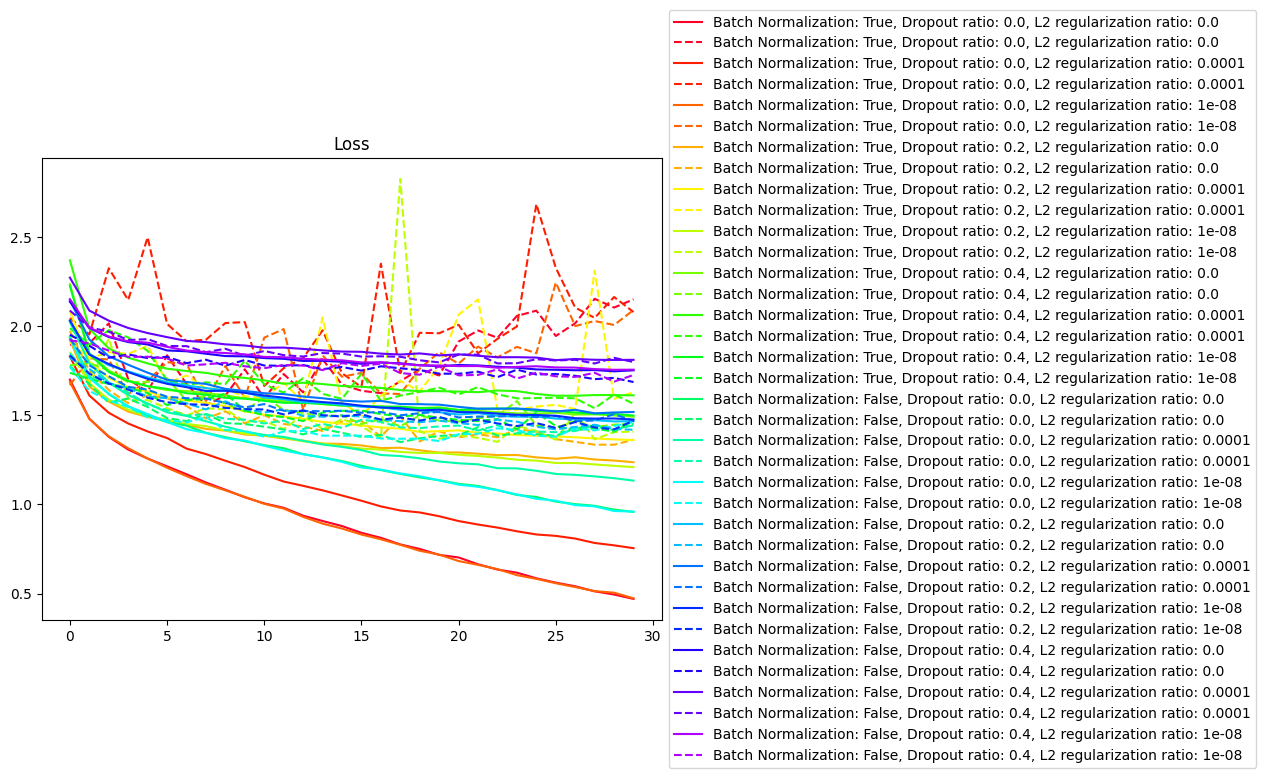

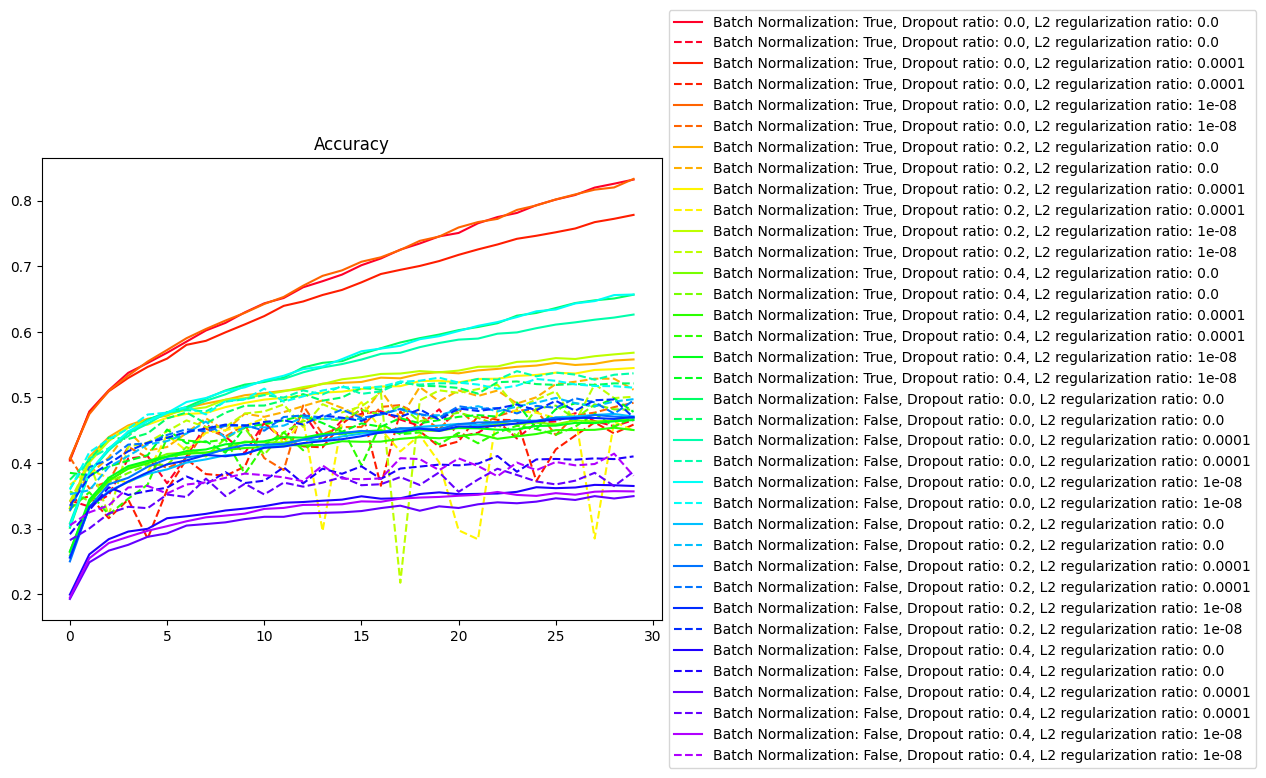

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()